# Necessary Imports

In [1]:
import argparse
import glob
import json
import os
import sys

import lightning as L
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import torch
import wandb
from matplotlib.colors import BoundaryNorm, ListedColormap
# import matplotlib.colors as mcolors
from PIL import Image
from torch.utils.tensorboard import SummaryWriter

from TissueLabeling.config import Configuration
from TissueLabeling.brain_utils import crop, load_brains, mapping
from TissueLabeling.models.segformer import Segformer
from TissueLabeling.models.unet import Unet
from TissueLabeling.models.simple_unet import SimpleUnet

2024-01-31 13:34:39.857656: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-31 13:34:39.857702: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-31 13:34:39.857728: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-31 13:34:39.863169: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-31 13:34:42.998657: W tensorflow/compiler/

# Harsha's plotting functions

In [2]:
def extract_numbers_names_colors(FreeSurferColorLUT=''):
    """
    Extract lists of numbers, names, and colors representing anatomical brain
    regions from FreeSurfer's FreeSurferColorLUT.txt lookup table file.

    Parameters
    ----------
    FreeSurferColorLUT : string
        full path to FreeSurferColorLUT.txt file (else uses local Python file)

    Returns
    -------
    numbers : list of integers
        numbers representing anatomical labels from FreeSurferColorLUT.txt
    names : list of integers
        names for anatomical regions from FreeSurferColorLUT.txt
    colors : list of integers
        colors associated with anatomical labels from FreeSurferColorLUT.txt

    Examples
    --------
    >>> from mindboggle.mio.labels import extract_numbers_names_colors # doctest: +SKIP
    >>> ennc = extract_numbers_names_colors # doctest: +SKIP
    >>> en1,en2,ec = ennc('/Applications/freesurfer/FreeSurferColorLUT.txt') # doctest: +SKIP

    """
    import os
    from io import open

    # from ext.mindboggle.FreeSurferColorLUT import lut_text

    def is_number(s):
        try:
            int(s)
            return True
        except ValueError:
            return False

    # if os.environ['FREESURFER_HOME']:
    #     FreeSurferColorLUT = os.path.join(
    #              os.environ['FREESURFER_HOME'], 'FreeSurferColorLUT.txt')
    if FreeSurferColorLUT and os.path.exists(FreeSurferColorLUT):
        f = open(FreeSurferColorLUT, 'r')
        lines = f.readlines()
    else:
        # lut = lut_text()
        # lines = lut.split('\n')
        lines = []

    numbers = []
    names = []
    colors = []
    for line in lines:
        strings = line.split()
        if strings and is_number(strings[0]):
            numbers.append(int(strings[0]))
            names.append(strings[1])
            colors.append([int(strings[2]), int(strings[3]),
                           int(strings[4])])

    return numbers, names, colors

In [3]:
def rgb_map_for_data():
    _, fs_names, fs_colors = extract_numbers_names_colors(
        "/om2/user/sabeen/freesurfer/distribution/FreeSurferColorLUT.txt"
    )

    with open("/om2/user/sabeen/readme", "r") as f:
        voxmorph_label_index = f.read().splitlines()

    # get the last 24 lines of the readme file (format--> id: name)
    voxmorph_label_index = [
        item.strip().split(":") for item in voxmorph_label_index if item != ""
    ][
        -24:
    ]  # HACK
    voxmorph_label_index = [
        [int(item[0]), item[1].strip()] for item in voxmorph_label_index
    ]
    voxmorph_label_index_dict = dict(voxmorph_label_index)
    my_colors = [
        fs_colors[fs_names.index(item)] for item in voxmorph_label_index_dict.values()
    ]

    return my_colors

In [171]:
def color_map_for_data():
    my_colors = rgb_map_for_data()
    cmap = ListedColormap(np.array(my_colors) / 255)

    # fig = plt.figure()
    # plt.imshow(np.arange(max(voxmorph_label_index_dict.keys()))[None], cmap=cmap)
    # plt.show()

    return cmap, my_colors

# Helper functions

In [5]:
def load_model(config, checkpoint_path = None):
    """
    Selects the model based on the model name provided in the config file.
    """
    if config.model_name == "segformer":
        model = Segformer(config.nr_of_classes, pretrained=config.pretrained)
    elif config.model_name == "unet":
        model = Unet(
            dim=16,
            channels=1,
            dim_mults=(2, 4, 8, 16, 32, 64),
        )
    elif config.model_name == "simple_unet":
        model = SimpleUnet(image_channels=1,nr_of_classes=config.nr_of_classes)
    else:
        print(f"Invalid model name provided: {config.model_name}")
        sys.exit()

    print(f"{config.model_name} found")
    if checkpoint_path:
        print(f"Loading from checkpoint...")
        if torch.cuda.is_available():
            model.load_state_dict(torch.load(checkpoint_path)['model'])
        else:
            model.load_state_dict(torch.load(checkpoint_path,map_location=torch.device('cpu'))['model'])
        
        # checkpoint path is something like: 'logdir/checkpoint_1000.chkpt'
        config.start_epoch = int(checkpoint_path.split('/')[-1].split('.')[0].split('_')[-1])

    return model

In [6]:
def get_config(logdir):
    """
    Gets the config file based on the command line arguments.
    """
    chkpt_folder = os.path.join('/om2/user/sabeen/tissue_labeling/results/', logdir)

    config_file = os.path.join(chkpt_folder, "config.json")
    if not os.path.exists(config_file):
        sys.exit(f"Configuration file not found at {config_file}")

    with open(config_file) as json_file:
        data = json.load(json_file)
    assert isinstance(data, dict), "Invalid Object Type"

    dice_list = sorted(glob.glob(os.path.join(chkpt_folder, "checkpoint*")))
    if not dice_list:
        sys.exit("No checkpoints exist to resume training")

    data["checkpoint"] = dice_list[-1]
    # data["start_epoch"] = int(os.path.basename(dice_list[0]).split('.')[0].split('_')[-1])

    args = argparse.Namespace(**data)
    config = Configuration(args, "config_resume.json")

    return config, dice_list

# Log Images Class

In [7]:
class Log_Images_v2:
    def __init__(
        self,
        # fabric: L.Fabric,
        config,
        writer=None,
    ):
        self.wandb_on = config.wandb_on
        self.pretrained = config.pretrained
        self.model_name = config.model_name
        self.nr_of_classes = config.nr_of_classes
        self.writer = writer
        if self.model_name == 'simple_unet':
            self.image_shape = (160,192)
        else:
            self.image_shape = (162,194)

        # color map to get always the same colors for classes
        colors = plt.cm.hsv(np.linspace(0, 1, config.nr_of_classes))
        # new plt cmap
        self.cmap = ListedColormap(colors)
        self.freesurfer_colors = color_map_for_data()
        # new plt norm
        bounds = np.arange(0, config.nr_of_classes + 1)
        self.norm = BoundaryNorm(bounds, self.cmap.N)

        print('Loading brains...')
        # load always the same image from validation set
        image_file = "pac_36_orig.nii.gz"
        mask_file = "pac_36_aseg.nii.gz"
        file_path = "/om2/user/matth406/nobrainer_data/data/SharedData/segmentation/freesurfer_asegs/"
        brain, mask, _ = load_brains(image_file, mask_file, file_path)
        mask_og = np.copy(mask)
        mask = mapping(mask,nr_of_classes=self.nr_of_classes)

        self.brain_slices, self.mask_slices = [], []

        # randomly select slices in 3 directions
        self.slice_idx = [125, 150]
        normalization_constants = np.load(
            "/om2/user/matth406/nobrainer_data_norm/data_prepared_medium/normalization_constants.npy"
        )
        self.brain_slices = torch.empty((len(self.slice_idx) * 3, 1, self.image_shape[0], self.image_shape[1]))
        self.mask_slices = torch.empty((len(self.slice_idx) * 3, 1, self.image_shape[0], self.image_shape[1]),dtype=torch.long)
        self.mask_slices_og = torch.empty((len(self.slice_idx) * 3, 1, self.image_shape[0], self.image_shape[1]),dtype=torch.long)

        print('Initializing logging_dict...')
        i = 0
        self.logging_dict = {}
        for d in range(3):
            for slice_id in self.slice_idx:
                if d == 0:
                    brain_slice = crop(brain[slice_id, :, :], self.image_shape[0], self.image_shape[1])
                    mask_slice = crop(mask[slice_id, :, :], self.image_shape[0], self.image_shape[1])
                    mask_slice_og = crop(mask_og[slice_id, :, :], self.image_shape[0], self.image_shape[1])
                if d == 1:
                    brain_slice = crop(brain[:, slice_id, :], self.image_shape[0], self.image_shape[1])
                    mask_slice = crop(mask[:, slice_id, :], self.image_shape[0], self.image_shape[1])
                    mask_slice_og = crop(mask_og[:, slice_id, :], self.image_shape[0], self.image_shape[1])
                if d == 2:
                    brain_slice = crop(brain[:, :, slice_id], self.image_shape[0], self.image_shape[1])
                    mask_slice = crop(mask[:, :, slice_id], self.image_shape[0], self.image_shape[1])
                    mask_slice_og = crop(mask_og[:, :, slice_id], self.image_shape[0], self.image_shape[1])

                self.logging_dict[f"Image d{d} c{slice_id}"] = self.__create_plot(
                    self.wandb_on, brain_slice, caption="Raw Image"
                )
                self.logging_dict[f"True Mask d{d} c{slice_id}"] = self.__create_plot(
                    self.wandb_on,
                    mask_slice,
                    caption="True Mask",
                    cmap=self.cmap,
                    norm=self.norm,
                    # fig_path=f'/om2/user/sabeen/true_mask_d{d}_c{slice_id}'
                )
                self.logging_dict[f"True Mask d{d} c{slice_id} (Freesurfer Colors)"] = self.__create_plot(
                    self.wandb_on,
                    mask_slice,
                    caption="True Mask",
                    cmap=self.freesurfer_colors,
                    norm=self.norm,
                    # fig_path=f'/om2/user/sabeen/true_mask_d{d}_c{slice_id}_fs'
                )
                self.logging_dict[f"True Mask OG d{d} c{slice_id} (Freesurfer Colors)"] = self.__create_plot(
                    self.wandb_on,
                    mask_slice_og,
                    caption="True Mask OG",
                    cmap=self.freesurfer_colors,
                    norm=self.norm,
                    # fig_path=f'/om2/user/sabeen/true_mask_d{d}_c{slice_id}_fs_og'
                )
                brain_slice = (
                    brain_slice - normalization_constants[0]
                ) / normalization_constants[1]
                brain_slice = torch.from_numpy(brain_slice).to(torch.float32)
                brain_slice = brain_slice[None, None]
                self.brain_slices[i] = brain_slice

                mask_slice = torch.tensor(mask_slice)[None, None].long()
                self.mask_slices[i] = mask_slice

                mask_slice_og = torch.tensor(mask_slice_og)[None, None].long()
                self.mask_slices_og[i] = mask_slice_og

                i += 1

        # send all slices to device
        if self.pretrained:
            self.brain_slices = self.brain_slices.repeat((1, 3, 1, 1))
        # self.brain_slices = fabric.to_device(self.brain_slices)
        # self.mask_slices = fabric.to_device(self.mask_slices)

    @staticmethod
    def __create_plot(
        wandb_on: bool,
        image: np.array,
        caption: str,
        cmap: str = "gray",
        norm: plt.Normalize = None,
        fig_path: str = None,
    ):
        """
        Creates a pyplot and adds it to the wandb image list.

        Args:
            image (np.array): image
            caption (str): caption of the plot
            cmap (str, optional): color map applied. Defaults to 'gray'.
            norm (plt.Normalize, optional): color normalization. Defaults to None.
            fig_path (str, optional): Path if figure should be save locally. Defaults to None.
        """
        fig, ax = plt.subplots()
        ax.imshow(image, cmap=cmap, norm=norm)
        ax.axis("off")
        fig.canvas.draw()
        if fig_path is not None:
            fig.savefig(fig_path)
        image = Image.frombytes(
            "RGB", fig.canvas.get_width_height(), fig.canvas.tostring_rgb()
        )
        if wandb_on:
            image = wandb.Image(image, caption=caption)
        plt.close()

        return image

    @torch.no_grad()
    def logging(self, model, e: int, commit: bool):
        model.eval()
        probs = model(self.brain_slices)
        probs = probs.argmax(1)
        probs = probs.cpu()
        model.train()

        i = 0
        logging_dict = {}
        for d in range(3):
            for slice_id in self.slice_idx:
                logging_dict[f"Predicted Mask d{d} c{slice_id}"] = self.__create_plot(
                    self.wandb_on,
                    probs[i],
                    caption=f"Epoch {e}",
                    cmap=self.cmap,
                    norm=self.norm,
                )
                logging_dict[f"Predicted Mask d{d} c{slice_id} (Freesurfer Colors)"] = self.__create_plot(
                    self.wandb_on,
                    probs[i],
                    caption=f"Epoch {e}",
                    cmap=self.freesurfer_colors,
                    norm=self.norm,
                )
                i += 1
        current_logging_dict = self.logging_dict | logging_dict
        if self.wandb_on:
            wandb.log(current_logging_dict, commit=commit)
        
        if self.writer is not None:
            print('Logging images...')
            for key, img in current_logging_dict.items():
                img = np.array(img)
                if len(img.shape) == 3:
                    self.writer.add_image(key, np.array(img), config.start_epoch, dataformats='HWC')
                elif len(img.shape) == 2:
                    self.writer.add_image(key, np.array(img), config.start_epoch, dataformats='HW')
        return current_logging_dict

# Experimenting

In [22]:
import cv2

In [8]:
logdir = '20240119-multi-4gpu-Msimple_unet\Ldice\C51\B374\A0'
config, checkpoint_paths = get_config(logdir)

writing config file...


In [9]:
wandb_on = config.wandb_on
pretrained = config.pretrained
model_name = config.model_name
nr_of_classes = config.nr_of_classes
writer = None
if model_name == 'simple_unet':
    image_shape = (160,192)
else:
    image_shape = (162,194)

In [10]:
colors = plt.cm.hsv(np.linspace(0, 1, config.nr_of_classes))
matth_cmap = ListedColormap(colors)
freesurfer_colors = color_map_for_data()
bounds = np.arange(0, config.nr_of_classes + 1)
norm = BoundaryNorm(bounds, matth_cmap.N)

rgb = colors[:,:-1] * 255
color_range = np.zeros((256,3))
color_range[:rgb.shape[0],:] = rgb
color_range = np.squeeze(np.dstack([color_range[:,2], color_range[:,1], color_range[:,0]]), 0)  # RGB => BGR

In [28]:
print('Loading brains...')
# load always the same image from validation set
image_file = "pac_36_orig.nii.gz"
mask_file = "pac_36_aseg.nii.gz"
file_path = "/om2/user/matth406/nobrainer_data/data/SharedData/segmentation/freesurfer_asegs/"
brain, mask, _ = load_brains(image_file, mask_file, file_path)

Loading brains...


In [29]:
mask_og = np.copy(mask)

In [30]:
new_mask = mapping(mask,nr_of_classes=config.nr_of_classes)

In [31]:
brain_slices, mask_slices, mask_slices_og = [], [], []

# randomly select slices in 3 directions
slice_idx = [125, 150]
normalization_constants = np.load(
    "/om2/user/matth406/nobrainer_data_norm/data_prepared_medium/normalization_constants.npy"
)
brain_slices = torch.empty((len(slice_idx) * 3, 1, image_shape[0], image_shape[1]))
mask_slices = torch.empty((len(slice_idx) * 3, 1, image_shape[0], image_shape[1]),dtype=torch.long)
mask_slices_og = torch.empty((len(slice_idx) * 3, 1, image_shape[0], image_shape[1]),dtype=torch.long)

In [32]:
print('Initializing logging_dict...')
i = 0
logging_dict = {}
for d in range(3):
    for slice_id in slice_idx:
        if d == 0:
            brain_slice = crop(brain[slice_id, :, :], image_shape[0], image_shape[1])
            mask_slice = crop(new_mask[slice_id, :, :],  image_shape[0],  image_shape[1])
            mask_slice_og = crop(mask_og[slice_id, :, :],  image_shape[0],  image_shape[1])
        if d == 1:
            brain_slice = crop(brain[:, slice_id, :],  image_shape[0],  image_shape[1])
            mask_slice = crop(new_mask[:, slice_id, :],  image_shape[0],  image_shape[1])
            mask_slice_og = crop(mask_og[:, slice_id, :],  image_shape[0],  image_shape[1])
        if d == 2:
            brain_slice = crop(brain[:, :, slice_id], image_shape[0], image_shape[1])
            mask_slice = crop(new_mask[:, :, slice_id], image_shape[0], image_shape[1])
            mask_slice_og = crop(mask_og[:, :, slice_id], image_shape[0], image_shape[1])

        # self.logging_dict[f"Image d{d} c{slice_id}"] = self.__create_plot(
        #     self.wandb_on, brain_slice, caption="Raw Image"
        # )
        # self.logging_dict[f"True Mask d{d} c{slice_id}"] = self.__create_plot(
        #     self.wandb_on,
        #     mask_slice,
        #     caption="True Mask",
        #     cmap=self.cmap,
        #     norm=self.norm,
        #     # fig_path=f'/om2/user/sabeen/true_mask_d{d}_c{slice_id}'
        # )
        # self.logging_dict[f"True Mask d{d} c{slice_id} (Freesurfer Colors)"] = self.__create_plot(
        #     self.wandb_on,
        #     mask_slice,
        #     caption="True Mask",
        #     cmap=self.freesurfer_colors,
        #     norm=self.norm,
        #     # fig_path=f'/om2/user/sabeen/true_mask_d{d}_c{slice_id}_fs'
        # )
        # self.logging_dict[f"True Mask OG d{d} c{slice_id} (Freesurfer Colors)"] = self.__create_plot(
        #     self.wandb_on,
        #     mask_slice_og,
        #     caption="True Mask OG",
        #     cmap=self.freesurfer_colors,
        #     norm=self.norm,
        #     # fig_path=f'/om2/user/sabeen/true_mask_d{d}_c{slice_id}_fs_og'
        # )
        brain_slice = (
            brain_slice - normalization_constants[0]
        ) / normalization_constants[1]
        brain_slice = torch.from_numpy(brain_slice).to(torch.float32)
        brain_slice = brain_slice[None, None]
        brain_slices[i] = brain_slice

        mask_slice = torch.tensor(mask_slice)[None, None].long()
        mask_slices[i] = mask_slice

        mask_slice_og = torch.tensor(mask_slice_og)[None, None].long()
        mask_slices_og[i] = mask_slice_og

        i += 1

# send all slices to device
if pretrained:
    brain_slices = brain_slices.repeat((1, 3, 1, 1))
# self.brain_slices = fabric.to_device(self.brain_slices)
# self.mask_slices = fabric.to_device(self.mask_slices)

Initializing logging_dict...


In [33]:
mask_slice_first = mask_slices[2,:,:,:].squeeze()
mask_slice_og_first = mask_slices_og[2,:,:,:].squeeze()

In [34]:
mask_slice_first_img = np.copy(mask_slice_first)
mask_slice_og_first_img = np.copy(mask_slice_og_first)

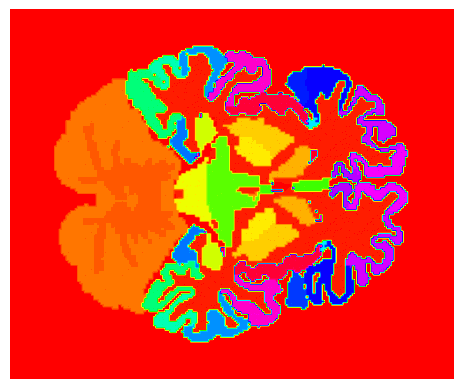

In [36]:
fig, ax = plt.subplots()
ax.imshow(mask_slice_first_img, cmap=matth_cmap, norm=norm)
ax.axis("off")
fig.canvas.draw()
# if fig_path is not None:
#     fig.savefig(fig_path)
# mask_slice_first_img = Image.frombytes(
#     "RGB", fig.canvas.get_width_height(), fig.canvas.tostring_rgb()
# )
# if wandb_on:
#     mask_slice_first_img = wandb.Image(mask_slice_first_img, caption=caption)

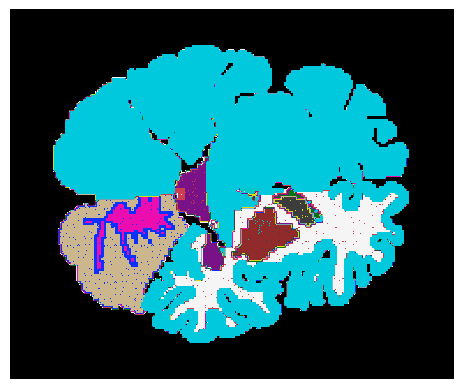

In [24]:
fig, ax = plt.subplots()
ax.imshow(mask_slice_og_first_img, cmap=freesurfer_colors, norm=norm)
ax.axis("off")
fig.canvas.draw()
# if fig_path is not None:
#     fig.savefig(fig_path)
# mask_slice_og_first_img = Image.frombytes(
#     "RGB", fig.canvas.get_width_height(), fig.canvas.tostring_rgb()
# )
# if wandb_on:
#     mask_slice_og_first_img = wandb.Image(mask_slice_og_first_img, caption=caption)

In [25]:
non_zero_indices = np.argwhere(np.copy(mask_slice_first) > 0)

# Find the bounding box coordinates
min_row, min_col = np.min(non_zero_indices, axis=0)
max_row, max_col = np.max(non_zero_indices, axis=0)

In [26]:
mask_slice_first_bounded = np.copy(mask_slice_first)[min_row:max_row,min_col:max_col]
mask_slice_og_first_bounded = np.copy(mask_slice_og_first)[min_row:max_row,min_col:max_col]

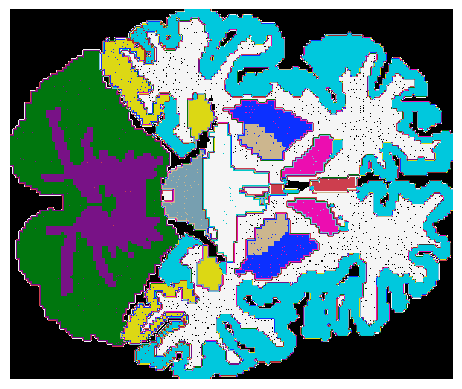

In [27]:
fig, ax = plt.subplots()
ax.imshow(mask_slice_first_bounded, cmap=freesurfer_colors, norm=norm)
ax.axis("off")
fig.canvas.draw()
# if fig_path is not None:
#     fig.savefig(fig_path)

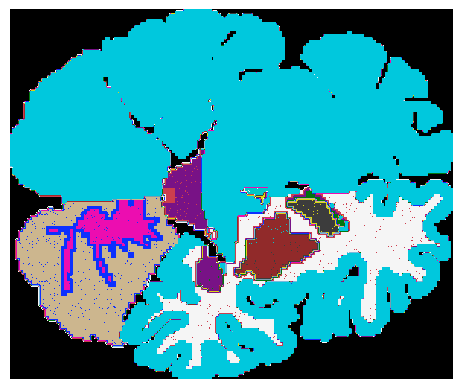

In [28]:
fig, ax = plt.subplots()
ax.imshow(mask_slice_og_first_bounded, cmap=freesurfer_colors, norm=norm)
ax.axis("off")
fig.canvas.draw()
# if fig_path is not None:
#     fig.savefig(fig_path)
# mask_slice_of_first_bounded = Image.frombytes(
#     "RGB", fig.canvas.get_width_height(), fig.canvas.tostring_rgb()
# )

In [29]:
non_zero_indices = np.argwhere(np.copy(mask_slice_og_first_bounded[0,:]) > 0)

# Find the bounding box coordinates
min_col = np.min(non_zero_indices, axis=0)
max_col = np.max(non_zero_indices, axis=0)

In [30]:
mask_slice_og_first_bounded[1,min_col-2]

array([2015])

# Using cv2

## Install and import

In [220]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 51.4 MB/s eta 0:00:00:00:0100:01

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [32]:
import cv2

## Code

In [180]:
image_gray = mask_slice_first.type(torch.uint8).numpy()
# image_gray = np.copy(mask_u8)

In [181]:
colors = plt.cm.hsv(np.linspace(0, 1, config.nr_of_classes))
# matth_cmap = ListedColormap(colors)
fs_cmap, freesurfer_colors = color_map_for_data()
# bounds = np.arange(0, config.nr_of_classes + 1)
# norm = BoundaryNorm(bounds, matth_cmap.N)

In [182]:
freesurfer_colors = np.array(freesurfer_colors)
freesurfer_colors.shape

(24, 3)

In [183]:
rgb = colors[:,:-1] * 255
color_range = np.zeros((256,3))
color_range[:rgb.shape[0],:] = rgb
# color_range = np.squeeze(np.dstack([color_range[:,2], color_range[:,1], color_range[:,0]]), 0)  # RGB => BGR

In [184]:
channels = [cv2.LUT(image_gray, color_range[:,i]) for i in range(3)]
new_img = np.dstack(channels)
# cv2.imwrite('/om2/user/sabeen/temp_cv2_matth_v2.png',new_img)

## Modifying Log_Images._create_plot()

In [ ]:
def __create_plot(
        wandb_on: bool,
        image: np.array,
        caption: str,
        cmap: str = "gray",
        norm: plt.Normalize = None,
        fig_path: str = None,
    ):
        """
        Creates a pyplot and adds it to the wandb image list.

        Args:
            image (np.array): image
            caption (str): caption of the plot
            cmap (str, optional): color map applied. Defaults to 'gray'.
            norm (plt.Normalize, optional): color normalization. Defaults to None.
            fig_path (str, optional): Path if figure should be save locally. Defaults to None.
        """
        fig, ax = plt.subplots()
        ax.imshow(image, cmap=cmap, norm=norm)
        ax.axis("off")
        fig.canvas.draw()
        if fig_path is not None:
            fig.savefig(fig_path)
        image = Image.frombytes(
            "RGB", fig.canvas.get_width_height(), fig.canvas.tostring_rgb()
        )
        if wandb_on:
            image = wandb.Image(image, caption=caption)
        plt.close()

        return image

In [198]:
def create_plot_v2(
        wandb_on: bool,
        image: np.array,
        caption: str,
        color_range,
        fig_path: str = None,
    ):
        image = image.type(torch.uint8).numpy()
        channels = [cv2.LUT(image, color_range[:,i]) for i in range(3)]
        new_img = np.dstack(channels)
        im = Image.fromarray(np.uint8(new_img))
    
        if fig_path is not None:
            new_img_bgr = np.dstack([channels[2],channels[1],channels[0]])
            cv2.imwrite(fig_path,new_img_bgr)
        image = Image.fromarray(np.uint8(new_img))
        if wandb_on:
            image = wandb.Image(image, caption=caption)

        return image

In [199]:
create_im = create_plot_v2(wandb_on=False,image=mask_slice_first,caption='True Mask',color_range=color_range)

In [185]:
im = Image.fromarray(np.uint8(new_img))

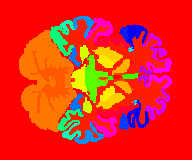

In [197]:
display(create_im)

In [187]:
new_img_bgr = np.dstack([channels[2],channels[1],channels[0]])

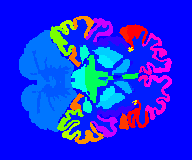

In [190]:
im2 = Image.fromarray(np.uint8(new_img_bgr))
display(im2)

In [203]:
brain_slice_first = brain_slices[2,:,:,:].squeeze()
brain_im = Image.fromarray(brain_slice_first)

AttributeError: 'Tensor' object has no attribute '__array_interface__'

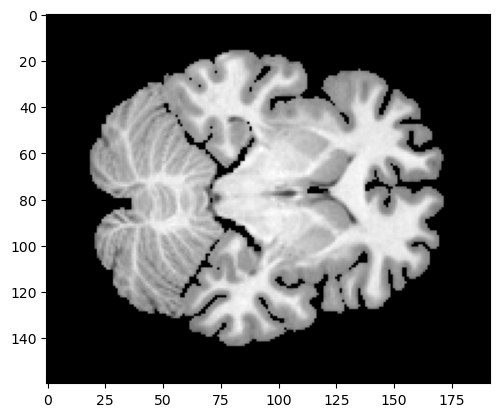

In [205]:
fig, ax = plt.subplots()
ax.imshow(brain_slice_first, cmap="gray", norm=None)

In [224]:
new_brain_slice = ((brain_slice_first - torch.min(brain_slice_first)) / (torch.max(brain_slice_first) - torch.min(brain_slice_first)) * 255).numpy().astype(np.uint8)

In [230]:
img_min = torch.min(brain_slice_first)
img_max = torch.max(brain_slice_first)
torch.min((brain_slice_first - img_min) / (img_max - img_min))

tensor(0.)

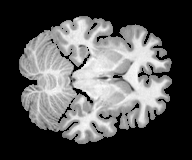

In [234]:
brain_im = Image.fromarray(new_brain_slice)
display(brain_im)

In [239]:
cv2.imwrite('/om2/user/sabeen/brain_temp.png',new_brain_slice)

True

In [238]:
new_brain_slice.shape

(160, 192)